# Margining Practices Simulation: Impact on Investor A and Dealer B

This notebook simulates the impact of margining practices (Initial Margin and Variation Margin) on two institutions:
- **Investor A**: Long position in a forward-like contract
- **Dealer B**: Short position (counterparty)

We model two default scenarios:
1. **Exogenous Only** — defaults driven purely by a random daily probability
2. **Augmented Model** — defaults driven by exogenous shocks **or** liquidity exhaustion (with fire-sale mechanics)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

# ── Parameters ──────────────────────────────────────────────
S0 = 100            # Initial asset price
K  = 100            # Strike price
Q  = 50             # Position size (Investor A is long)
sigma_s = 0.1     # Daily volatility
T  = 504            # Contract maturity (days)
T_sim = 252         # Simulation window (trading days)
N  = 10_000         # Number of Monte-Carlo simulations
MPOR = 10           # Margin period of risk (days)
p_default = 0.005   # Daily exogenous probability of default
L0 = 3_000          # Initial liquid assets (Cash)
A0 = 6_000          # Initial illiquid assets
h  = 0.15           # Fire-sale discount

# ── Initial Margin (IM) ────────────────────────────────────
# 99 % one-sided VaR over the MPOR
IM = 2.33 * Q * sigma_s * np.sqrt(MPOR)

print(f"Initial Margin (IM): {IM:,.2f}")
print(f"Parameters loaded — {N:,} simulations × {T_sim} days")

Initial Margin (IM): 36.84
Parameters loaded — 10,000 simulations × 252 days


## 1. Generate Price Paths

Asset price dynamics: $S_{t+1} - S_t \sim \mathcal{N}(0, \sigma_s^2)$

We generate all paths at once in a vectorized manner for efficiency.

Price paths shape: (10000, 263)
MTM matrix shape:  (10000, 263)
VM matrix shape:   (10000, 262)


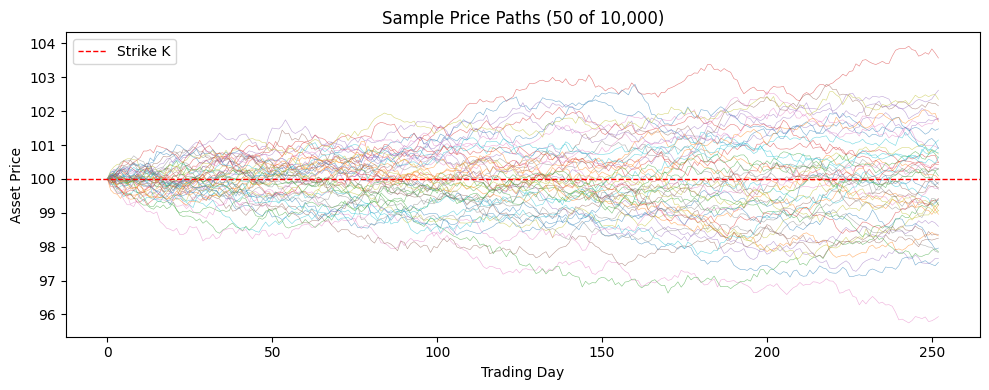

In [18]:
# We need T_sim + MPOR extra days so we can close-out after a last-day default
total_days = T_sim + MPOR

# Generate increments:  dS ~ N(0, sigma_s^2)
dS = np.random.normal(0, sigma_s, size=(N, total_days))

# Build price paths (N × total_days+1) — column 0 is S0
S = np.zeros((N, total_days + 1))
S[:, 0] = S0
S[:, 1:] = S0 + np.cumsum(dS, axis=1)

# Mark-to-market value: V_t = Q * (S_t - K)
V = Q * (S - K)

# Daily VM calls: VM_t = V_t - V_{t-1}  (positive means A pays B)
VM = np.diff(V, axis=1)  # shape (N, total_days)

print(f"Price paths shape: {S.shape}")
print(f"MTM matrix shape:  {V.shape}")
print(f"VM matrix shape:   {VM.shape}")

# Quick sanity plot — 50 sample paths
fig, ax = plt.subplots(figsize=(10, 4))
for i in range(50):
    ax.plot(S[i, :T_sim+1], lw=0.4, alpha=0.6)
ax.set_xlabel("Trading Day")
ax.set_ylabel("Asset Price")
ax.set_title("Sample Price Paths (50 of 10,000)")
ax.axhline(K, color="red", ls="--", lw=1, label="Strike K")
ax.legend()
plt.tight_layout()
plt.show()

## 2. Scenario 1 — Exogenous Default Only

Investor A defaults on day $t$ if a uniform draw $u_t < p_{\text{default}} = 0.005$.

If default occurs at $t$, the position is closed out at $t + \text{MPOR}$.

$$\text{Loss}_B = \max\!\big(0,\;-(V_{t+\text{MPOR}} - V_t) - \text{IM}\big)$$

In [19]:
# ── Scenario 1: Exogenous Default Only ──────────────────────
losses_s1 = []            # B's losses (one per simulation)
default_days_s1 = []      # day of default (NaN if no default)

for i in range(N):
    defaulted = False
    for t in range(1, T_sim + 1):       # t = 1 … 252
        u = np.random.uniform()
        if u < p_default:                # exogenous default
            defaulted = True
            t_close = t + MPOR           # close-out day
            # B's loss: IM cushion minus MTM move over MPOR
            mtm_drop = V[i, t_close] - V[i, t]
            loss = max(0.0, -mtm_drop - IM)
            losses_s1.append(loss)
            default_days_s1.append(t)
            break
    if not defaulted:
        losses_s1.append(0.0)
        default_days_s1.append(np.nan)

losses_s1 = np.array(losses_s1)
default_days_s1 = np.array(default_days_s1)

n_defaults_s1 = np.sum(~np.isnan(default_days_s1))
print(f"Scenario 1 — Defaults: {n_defaults_s1:,} / {N:,}  "
      f"({n_defaults_s1/N*100:.1f}%)")

Scenario 1 — Defaults: 7,160 / 10,000  (71.6%)


## 3. Scenario 2 — Augmented Model (Exogenous + Liquidity)

Investor A defaults if:
- **(a)** the exogenous shock occurs, **OR**
- **(b)** A cannot meet the VM call even after fire-selling illiquid assets at a $h = 15\%$ discount.

**Liquidity logic:**
- If $\text{VM call} > \text{Cash}$, sell illiquid assets: cash raised $= \text{assets sold} \times (1 - h)$.
- **Insolvency** if $\text{VM call} > \text{Cash} + A_{\text{illiquid}} \times (1 - h)$.

In [20]:
# ── Scenario 2: Augmented Model (Exogenous + Liquidity) ─────
losses_s2 = []
default_days_s2 = []
default_cause  = []        # 'exogenous', 'liquidity', or None
total_fire_sale_costs = []  # cumulative fire-sale cost per sim

for i in range(N):
    cash     = L0           # liquid assets
    illiquid = A0           # illiquid assets
    fire_cost = 0.0         # running fire-sale cost for this path
    defaulted = False

    for t in range(1, T_sim + 1):
        # ── (a) Exogenous default check ──
        u = np.random.uniform()
        if u < p_default:
            defaulted = True
            t_close = t + MPOR
            mtm_drop = V[i, t_close] - V[i, t]
            loss = max(0.0, -mtm_drop - IM)
            losses_s2.append(loss)
            default_days_s2.append(t)
            default_cause.append("exogenous")
            total_fire_sale_costs.append(fire_cost)
            break

        # ── Daily VM call ──
        vm_call = VM[i, t - 1]  # V_t - V_{t-1}; positive → A pays

        if vm_call > 0:
            # A needs to pay vm_call
            if vm_call <= cash:
                cash -= vm_call
            else:
                shortfall = vm_call - cash
                # Illiquid assets needed to raise 'shortfall' in cash
                assets_to_sell = shortfall / (1 - h)
                if assets_to_sell <= illiquid:
                    illiquid -= assets_to_sell
                    fire_cost += assets_to_sell * h   # cost = discount
                    cash = 0.0                        # fully drained
                else:
                    # ── (b) Liquidity default ──
                    defaulted = True
                    t_close = t + MPOR
                    mtm_drop = V[i, t_close] - V[i, t]
                    loss = max(0.0, -mtm_drop - IM)
                    losses_s2.append(loss)
                    default_days_s2.append(t)
                    default_cause.append("liquidity")
                    total_fire_sale_costs.append(fire_cost)
                    break
        else:
            # A receives cash (VM is negative → price fell, A gets paid)
            cash -= vm_call   # vm_call < 0, so cash increases

    if not defaulted:
        losses_s2.append(0.0)
        default_days_s2.append(np.nan)
        default_cause.append(None)
        total_fire_sale_costs.append(fire_cost)

losses_s2 = np.array(losses_s2)
default_days_s2 = np.array(default_days_s2)
total_fire_sale_costs = np.array(total_fire_sale_costs)

n_defaults_s2 = np.sum(~np.isnan(default_days_s2))
n_exo  = sum(1 for c in default_cause if c == "exogenous")
n_liq  = sum(1 for c in default_cause if c == "liquidity")

print(f"Scenario 2 — Total Defaults: {n_defaults_s2:,} / {N:,}  "
      f"({n_defaults_s2/N*100:.1f}%)")
print(f"  ├─ Exogenous defaults : {n_exo:,}  "
      f"({n_exo/max(n_defaults_s2,1)*100:.1f}% of defaults)")
print(f"  └─ Liquidity defaults : {n_liq:,}  "
      f"({n_liq/max(n_defaults_s2,1)*100:.1f}% of defaults)")
print(f"\nTotal fire-sale costs (all sims): {total_fire_sale_costs.sum():,.2f}")
print(f"Mean fire-sale cost per sim:      {total_fire_sale_costs.mean():,.2f}")

Scenario 2 — Total Defaults: 7,222 / 10,000  (72.2%)
  ├─ Exogenous defaults : 7,222  (100.0% of defaults)
  └─ Liquidity defaults : 0  (0.0% of defaults)

Total fire-sale costs (all sims): 0.00
Mean fire-sale cost per sim:      0.00


## 4. Loss Distribution Analysis

### Expected Loss & 99% Expected Shortfall (CVaR)

- **Expected Loss** $= \frac{1}{N}\sum_{i=1}^{N} L_i$
- **99% ES** $= \mathbb{E}[L \mid L > \text{VaR}_{99\%}]$

In [21]:
# ── Risk Metrics ────────────────────────────────────────────
def compute_risk_metrics(losses, label):
    """Compute and print Expected Loss, 99% VaR, and 99% ES."""
    el = losses.mean()
    var99 = np.percentile(losses, 99)
    # Expected Shortfall: mean of losses exceeding the 99% VaR
    tail = losses[losses >= var99]
    es99 = tail.mean() if len(tail) > 0 else 0.0
    print(f"\n{'─'*50}")
    print(f"  {label}")
    print(f"{'─'*50}")
    print(f"  Expected Loss        : {el:>10,.2f}")
    print(f"  99% VaR              : {var99:>10,.2f}")
    print(f"  99% Expected Shortfall: {es99:>10,.2f}")
    print(f"{'─'*50}")
    return el, var99, es99

el1, var1, es1 = compute_risk_metrics(losses_s1, "Scenario 1 — Exogenous Only")
el2, var2, es2 = compute_risk_metrics(losses_s2, "Scenario 2 — Augmented Model")


──────────────────────────────────────────────────
  Scenario 1 — Exogenous Only
──────────────────────────────────────────────────
  Expected Loss        :       0.04
  99% VaR              :       0.00
  99% Expected Shortfall:       0.04
──────────────────────────────────────────────────

──────────────────────────────────────────────────
  Scenario 2 — Augmented Model
──────────────────────────────────────────────────
  Expected Loss        :       0.04
  99% VaR              :       0.00
  99% Expected Shortfall:       0.04
──────────────────────────────────────────────────


### Histograms of Loss Distributions

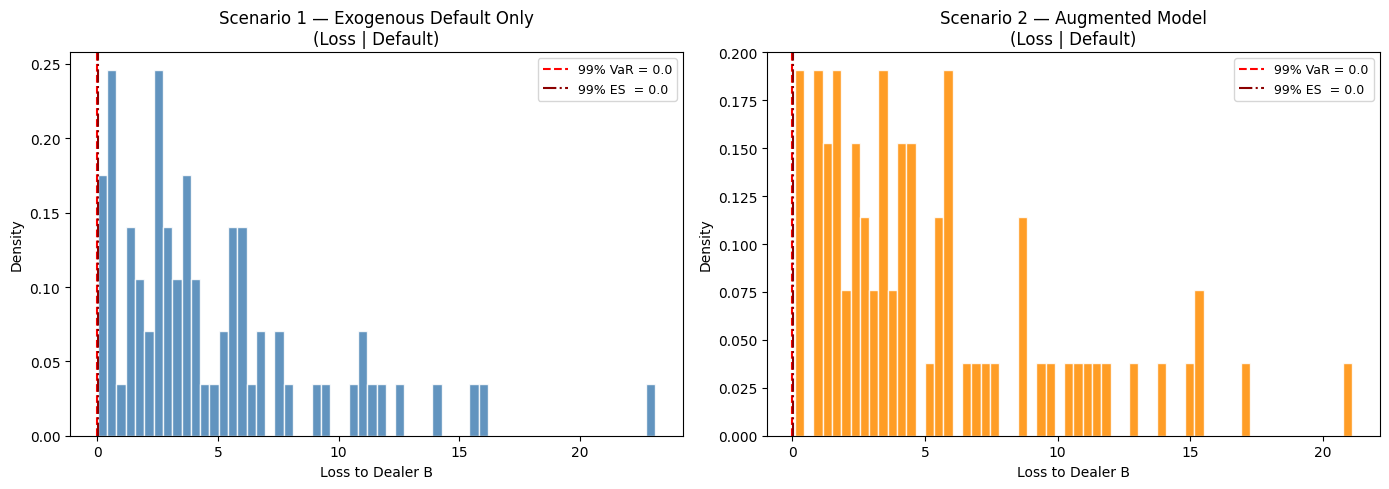

In [22]:
# ── Loss Histograms ─────────────────────────────────────────
# Filter to only simulations where a default (and hence a loss > 0) occurred
pos_losses_s1 = losses_s1[losses_s1 > 0]
pos_losses_s2 = losses_s2[losses_s2 > 0]

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# Scenario 1
axes[0].hist(pos_losses_s1, bins=60, color="steelblue", edgecolor="white",
             alpha=0.85, density=True)
axes[0].axvline(var1, color="red", ls="--", lw=1.5,
                label=f"99% VaR = {var1:,.1f}")
axes[0].axvline(es1, color="darkred", ls="-.", lw=1.5,
                label=f"99% ES  = {es1:,.1f}")
axes[0].set_title("Scenario 1 — Exogenous Default Only\n(Loss | Default)")
axes[0].set_xlabel("Loss to Dealer B")
axes[0].set_ylabel("Density")
axes[0].legend(fontsize=9)

# Scenario 2
axes[1].hist(pos_losses_s2, bins=60, color="darkorange", edgecolor="white",
             alpha=0.85, density=True)
axes[1].axvline(var2, color="red", ls="--", lw=1.5,
                label=f"99% VaR = {var2:,.1f}")
axes[1].axvline(es2, color="darkred", ls="-.", lw=1.5,
                label=f"99% ES  = {es2:,.1f}")
axes[1].set_title("Scenario 2 — Augmented Model\n(Loss | Default)")
axes[1].set_xlabel("Loss to Dealer B")
axes[1].set_ylabel("Density")
axes[1].legend(fontsize=9)

plt.tight_layout()
plt.show()

## 5. Scenario 2 Deep-Dive: Fire-Sale Costs & Default Causes

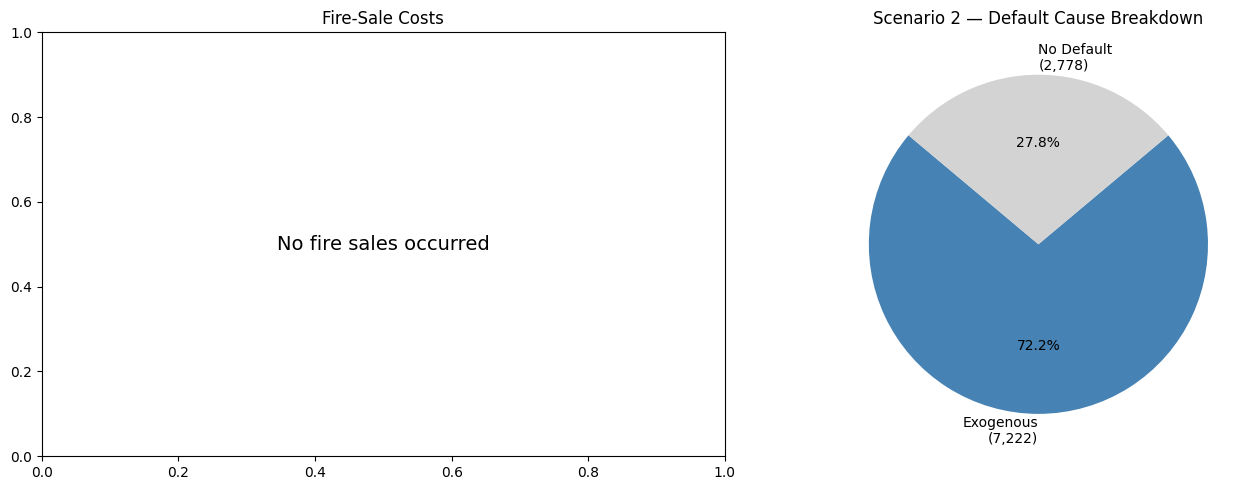


Paths with at least one fire sale: 0 / 10,000  (0.0%)



In [23]:
# ── Scenario 2: Fire-sale analysis & default breakdown ──────

# Fire-sale costs only for paths that actually had fire-sales
fs_nonzero = total_fire_sale_costs[total_fire_sale_costs > 0]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (a) Fire-sale cost distribution
if len(fs_nonzero) > 0:
    axes[0].hist(fs_nonzero, bins=50, color="firebrick", edgecolor="white",
                 alpha=0.85, density=True)
    axes[0].axvline(fs_nonzero.mean(), color="black", ls="--", lw=1.5,
                    label=f"Mean = {fs_nonzero.mean():,.1f}")
    axes[0].set_title("Distribution of Fire-Sale Costs\n(Paths with Fire Sales)")
    axes[0].set_xlabel("Cumulative Fire-Sale Cost")
    axes[0].set_ylabel("Density")
    axes[0].legend()
else:
    axes[0].text(0.5, 0.5, "No fire sales occurred", ha="center", va="center",
                 transform=axes[0].transAxes, fontsize=14)
    axes[0].set_title("Fire-Sale Costs")

# (b) Default cause breakdown (pie chart)
labels = []
sizes  = []
colors = []
if n_exo > 0:
    labels.append(f"Exogenous\n({n_exo:,})")
    sizes.append(n_exo)
    colors.append("steelblue")
if n_liq > 0:
    labels.append(f"Liquidity\n({n_liq:,})")
    sizes.append(n_liq)
    colors.append("darkorange")
n_no_def = N - n_defaults_s2
if n_no_def > 0:
    labels.append(f"No Default\n({n_no_def:,})")
    sizes.append(n_no_def)
    colors.append("lightgrey")

axes[1].pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%",
            startangle=140, textprops={"fontsize": 10})
axes[1].set_title("Scenario 2 — Default Cause Breakdown")

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nPaths with at least one fire sale: "
      f"{len(fs_nonzero):,} / {N:,}  ({len(fs_nonzero)/N*100:.1f}%)")
print(f"Mean fire-sale cost (conditional): {fs_nonzero.mean():,.2f}" if len(fs_nonzero) > 0 else "")

## 6. Summary Comparison Table

In [24]:
# ── Summary Comparison ──────────────────────────────────────
header = f"{'Metric':<35} {'Scenario 1':>14} {'Scenario 2':>14}"
sep    = "─" * len(header)

print(sep)
print(header)
print(sep)
print(f"{'Initial Margin (IM)':<35} {IM:>14,.2f} {IM:>14,.2f}")
print(f"{'Total Defaults':<35} {n_defaults_s1:>14,} {n_defaults_s2:>14,}")
print(f"{'Default Rate':<35} {n_defaults_s1/N*100:>13.1f}% {n_defaults_s2/N*100:>13.1f}%")
print(f"{'  — Exogenous':<35} {n_defaults_s1:>14,} {n_exo:>14,}")
print(f"{'  — Liquidity':<35} {'N/A':>14} {n_liq:>14,}")
print(f"{'Expected Loss (B)':<35} {el1:>14,.2f} {el2:>14,.2f}")
print(f"{'99% VaR (B)':<35} {var1:>14,.2f} {var2:>14,.2f}")
print(f"{'99% Expected Shortfall (B)':<35} {es1:>14,.2f} {es2:>14,.2f}")
print(f"{'Total Fire-Sale Costs (A)':<35} {'N/A':>14} {total_fire_sale_costs.sum():>14,.2f}")
print(sep)

─────────────────────────────────────────────────────────────────
Metric                                  Scenario 1     Scenario 2
─────────────────────────────────────────────────────────────────
Initial Margin (IM)                          36.84          36.84
Total Defaults                               7,160          7,222
Default Rate                                 71.6%          72.2%
  — Exogenous                                7,160          7,222
  — Liquidity                                  N/A              0
Expected Loss (B)                             0.04           0.04
99% VaR (B)                                   0.00           0.00
99% Expected Shortfall (B)                    0.04           0.04
Total Fire-Sale Costs (A)                      N/A           0.00
─────────────────────────────────────────────────────────────────
